# Proyecto 02:  Análisis de mercado inmobiliario (Parte 2)


## Problema

Recientemente te has incorporado al equipo de Datos de una gran inmobiliaria. La primera tarea que se te asigna es ayudar a los tasadores/as a valuar las propiedades, ya que es un proceso difícil y, a veces, subjetivo. Para ello, propones crear un modelo de Machine Learning que, dadas ciertas características de la propiedad, prediga su precio de venta.

## Resolución 

* Parte A - Transformación de Datos
* Parte B - Modelos Avanzados
* Parte C - Interpretación de modelos

***
***


### Parte A - Transformación de Datos
En esta parte del proyecto se trabajará sobre la base de datos, aplicando técnicas y métodos, adquiridos a lo largo del curso, para entrenar el modelo. 

 0. Importo las librerías necesarias para trabajar.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="Blues_d")

***
1. Importo la base de datos.

Para este proyecto se utiliza la base de datos de Properati, al igual que para el proyecto 1.

In [2]:
properati=pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
data=properati.copy()
data.drop_duplicates(inplace=True)
data.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


***
2. filtro de datos. 

Se realiza un filtro primario sobre la base de datos, se descartarán las columnas que no se considerarán para el modelo.

* Columnas que no se consideraran:
    * `start_date`
    * `end_date`
    * `created_on`
    * `l1`
    * `currency`
    * `title`
    * `description`
    * `operation_type`


In [3]:
data.drop(['start_date','end_date','created_on','l1','currency','title','description','operation_type'],axis=1, inplace=True)


* Property type

Se realiza un análisis en detalle de la columna `property_type` y se observa que los tipos de propiedades `Departamento`, `Casa` y `PH` superan ampliamente al resto de los tipos de propiedades. Solo se considerarán estos tipos, debido a que la data del resto de las propiedades es pequeña y pierde relevancia dentro del modelo. 



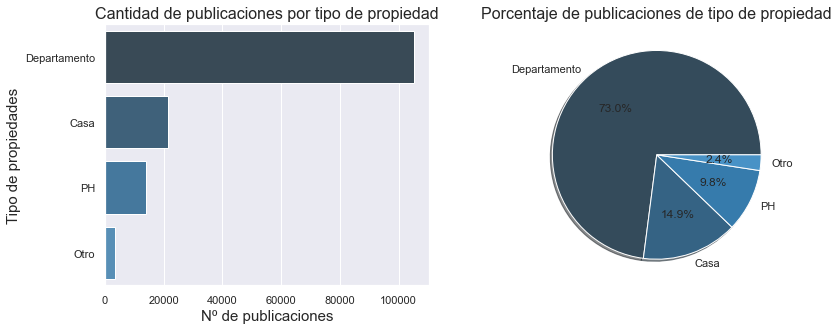

In [4]:
prop=['Lote','Oficina','Local comercial','Casa de campo','Depósito','Cochera']
prop_nueva=['Otro','Otro','Otro','Otro','Otro','Otro']
properati2=data.replace(prop,prop_nueva)

fig=plt.figure(figsize = (6.4*2,4.8))
plt.subplot(1,2,1)
sns.countplot(y= 'property_type', data=properati2,order = properati2['property_type'].value_counts().index)
plt.title('Cantidad de publicaciones por tipo de propiedad',fontsize=16)
plt.ylabel('Tipo de propiedades',fontsize=15)
plt.xlabel('Nº de publicaciones',fontsize=15)

plt.subplot(1,2,2)
plt.pie(properati2.property_type.value_counts(normalize=True), labels=properati2.property_type.value_counts().index,autopct='%1.1f%%',shadow=True)
plt.title('Porcentaje de publicaciones de tipo de propiedad',fontsize=16)

plt.show()

In [5]:
data=data[((data.property_type=='Departamento')|(data.property_type=='PH')|(data.property_type=='Casa'))]

***
3. Valores faltantes

A continuación se observaran los valores faltantes para cada columna. 

In [6]:
print('Cantidad de valores vacíos por cada columna: ')
print(np.sum(data.isna()))

Cantidad de valores vacíos por cada columna: 
lat                 9242
lon                 9273
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           4182
surface_total      18369
surface_covered    18646
price                  0
property_type          0
dtype: int64


Los valores faltantes de las columnas `lat` y `lon` serán ignorados debido a que no entraran en el modelo, por lo que no van a perjudicar los valores faltantes, y el tipo de dato de esas columnas es particular, siendo latitudes y longitudes, no se pueden completar simplemente ya que son únicos y no dependen de otro dato.

* `Bathrooms`

Para el caso de los datos faltantes de `bathrooms`. Se busco la mediana de `bathrooms` por cada valor de `rooms` y se reemplazaron los valores faltantes según los valores correspondientes de `rooms`. Se completan los valores faltantes con la mediana para no generar demasiadas alteraciones al dataset. 

In [7]:
values=data.bathrooms.groupby([data['rooms']]).agg(['median'])
values['median']=round(values['median'],0)
values

,median
rooms,
1.0,1.0
2.0,1.0
3.0,1.0
4.0,2.0
5.0,2.0
6.0,3.0
7.0,3.0
8.0,3.0
9.0,4.0


In [8]:
data=data.join(values,on='rooms')
data.bathrooms.fillna(data['median'],inplace=True)
data.drop(['median'],axis=1,inplace=True)


En el caso de `surface_total` y `surface_covered` se dividio en dos casos distintos. 

* `surface_total`/`Surface_covered`


El primero es cuando, dentro de una propiedad, hay valor de uno, pero falta del otro. Para estos casos de decidió completar el valor faltante con el valor obtenido, De esta manera respeto el dato ya obtenido. 

In [9]:
data[(pd.isnull(data.surface_total))&(pd.notnull(data.surface_covered))]

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
2506,NaN,NaN,Capital Federal,Palermo,3.0,2.0,1.0,NaN,1.0,236000.0,Departamento
3172,-34.614152,-58.465822,Capital Federal,Villa General Mitre,4.0,3.0,1.0,NaN,75.0,210000.0,Departamento
3859,-34.585148,-58.587445,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,3.0,2.0,1.0,NaN,76.0,60000.0,Departamento
4082,-34.633890,-58.489153,Capital Federal,Floresta,3.0,2.0,1.0,NaN,65.0,124000.0,Departamento
4257,-34.423063,-58.659132,Bs.As. G.B.A. Zona Norte,Tigre,2.0,1.0,1.0,NaN,1.0,165000.0,Departamento
...,...,...,...,...,...,...,...,...,...,...,...
145571,NaN,NaN,Bs.As. G.B.A. Zona Sur,Esteban Echeverría,4.0,3.0,2.0,NaN,150.0,180000.0,Casa
145588,-34.587729,-58.396706,Capital Federal,Recoleta,4.0,3.0,1.0,NaN,110.0,330000.0,Departamento
145608,-34.569280,-58.478443,Capital Federal,Belgrano,6.0,4.0,3.0,NaN,250.0,550000.0,Casa
145640,-34.708806,-58.387257,Bs.As. G.B.A. Zona Sur,Lanús,3.0,2.0,1.0,NaN,1.0,95000.0,Departamento


In [10]:
data.surface_total.fillna(data.surface_covered,inplace=True)

In [11]:
data[(pd.notnull(data.surface_total))&(pd.isnull(data.surface_covered))]

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
722,-34.577620,-58.465122,Capital Federal,Colegiales,2.0,1.0,1.0,35.0,NaN,89000.0,Departamento
913,-34.598850,-58.364006,Capital Federal,Puerto Madero,3.0,2.0,3.0,165.0,NaN,690000.0,Departamento
3094,-34.915098,-57.934335,Bs.As. G.B.A. Zona Sur,La Plata,3.0,2.0,1.0,70.0,NaN,75000.0,Departamento
3434,NaN,NaN,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,3.0,2.0,1.0,430.0,NaN,250000.0,Casa
3892,-34.771336,-58.421744,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,6.0,3.0,2.0,315.0,NaN,177000.0,Casa
...,...,...,...,...,...,...,...,...,...,...,...
145596,-34.583166,-58.406006,Capital Federal,Barrio Norte,4.0,3.0,3.0,286.0,NaN,1800000.0,Departamento
145607,NaN,NaN,Bs.As. G.B.A. Zona Oeste,Moreno,6.0,4.0,5.0,511.0,NaN,1200000.0,Casa
145610,-34.579296,-58.451458,Capital Federal,Colegiales,4.0,4.0,1.0,162.0,NaN,395000.0,Casa
145619,-34.596275,-58.374802,Capital Federal,Retiro,5.0,4.0,6.0,200.0,NaN,750000.0,Departamento


In [12]:
data.surface_covered.fillna(data.surface_total,inplace=True)


* `Surface Total` & `Surfeace Covered`

El segundo caso es cuando hay valores faltantes para ambas columnas. Para estos casos se utilizó el mismo método que en `bathrooms`, buscar la mediana de `surface_total` y `surface_covered` según la cantidad de `rooms` y reemplazar esos valores en los valores faltantes.

In [13]:
data[(pd.isnull(data.surface_total))&(pd.isnull(data.surface_covered))]

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
723,NaN,NaN,Bs.As. G.B.A. Zona Oeste,La Matanza,2.0,1.0,1.0,NaN,NaN,75000.0,Departamento
727,NaN,NaN,Bs.As. G.B.A. Zona Oeste,La Matanza,2.0,1.0,1.0,NaN,NaN,75000.0,Departamento
728,NaN,NaN,Bs.As. G.B.A. Zona Oeste,La Matanza,2.0,1.0,1.0,NaN,NaN,75000.0,Departamento
890,NaN,NaN,Bs.As. G.B.A. Zona Oeste,La Matanza,3.0,2.0,1.0,NaN,NaN,120000.0,Departamento
891,NaN,NaN,Bs.As. G.B.A. Zona Oeste,La Matanza,3.0,2.0,1.0,NaN,NaN,95000.0,Departamento
...,...,...,...,...,...,...,...,...,...,...,...
145551,-34.624841,-58.739126,Bs.As. G.B.A. Zona Oeste,Moreno,4.0,3.0,2.0,NaN,NaN,72000.0,Casa
145553,-34.639001,-58.647334,Bs.As. G.B.A. Zona Oeste,Morón,4.0,3.0,1.0,NaN,NaN,170000.0,Casa
145562,-34.995480,-58.469635,Bs.As. G.B.A. Zona Sur,San Vicente,4.0,3.0,2.0,NaN,NaN,360000.0,Casa
145597,-34.566424,-58.501889,Capital Federal,Villa Urquiza,4.0,3.0,2.0,NaN,NaN,259000.0,Departamento


In [14]:
values=data.surface_total.groupby([data['rooms']]).agg(['median'])
values['median']=round(values['median'],0)
values

,median
rooms,
1.0,37.0
2.0,49.0
3.0,79.0
4.0,130.0
5.0,214.0
6.0,287.0
7.0,350.0
8.0,382.0
9.0,436.0


In [15]:
data=data.join(values,on='rooms')
data.surface_total.fillna(data['median'],inplace=True)
data.drop(['median'],axis=1,inplace=True)

In [16]:
values=data.surface_covered.groupby([data['rooms']]).agg(['median'])
values['median']=round(values['median'],0)
values

,median
rooms,
1.0,34.0
2.0,44.0
3.0,69.0
4.0,110.0
5.0,165.0
6.0,219.0
7.0,255.0
8.0,280.0
9.0,315.0


In [17]:
data=data.join(values,on='rooms')
data.surface_covered.fillna(data['median'],inplace=True)
data.drop(['median'],axis=1,inplace=True)

Después de completar los valores faltantes con las medianas, se observaron 3 propiedades que aun conservaban los valores vacíos. Esto se debe a que todos los valores de `surface_total` y `surface_covered` con 25 `rooms` son valores vacíos, por lo que no se pudo obtener un valor para completar. 

Siendo simplemente 3 filas se decidió eliminarlas.

In [18]:
index=data[data['surface_total'].isna()].index
data.drop(index,inplace=True)

In [19]:
print('Cantidad de valores vacíos por cada columna: ')
print(np.sum(data.isna()))

Cantidad de valores vacíos por cada columna: 
lat                9242
lon                9273
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered       0
price                 0
property_type         0
dtype: int64


***
4. Valores atípicos

Para los valores atípicos se decidió utilizar el método de las 3 sigmas sobre todas las columnas que se utilizaran en el modelo.

In [20]:
def sigma_3(data,column):
    
    fig=plt.figure(figsize = (6.4*2,5))
    plt.subplot(2,2,1)
    sns.distplot(data[column],kde=False,bins=20)
    
    plt.subplot(2,2,2)
    sns.boxplot(data[column])
    
    fil=data.shape[0]
    
    sd=data[column].std(ddof=1)
    mean=data[column].mean()
    minimo=mean-3*sd
    maximo=mean+3*sd
    print('valor minimo:', minimo)
    print('valor maximo:', maximo)
    data=data[(data[column]>minimo)&(data[column]<maximo)]
    
    plt.subplot(2,2,3)
    sns.distplot(data[column],kde=False,bins=22)
    
    plt.subplot(2,2,4)
    sns.boxplot(data[column])
    fig.suptitle(column,fontsize=20)
    
    fil=fil-data.shape[0]
    print('Filas descartadas:',fil)
    return data

    

* `Price`

valor minimo: -620696.5137283654
valor maximo: 1095108.0152906436
Filas descartadas: 2460


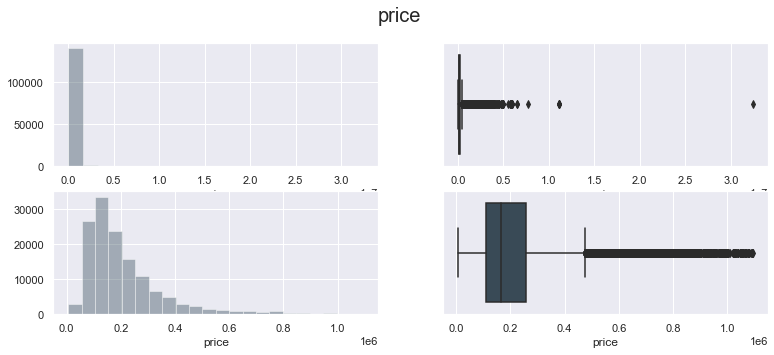

In [21]:
data=sigma_3(data,'price')

* `Surface Covered`

valor minimo: -2504.237022297
valor maximo: 2714.193541522209
Filas descartadas: 200


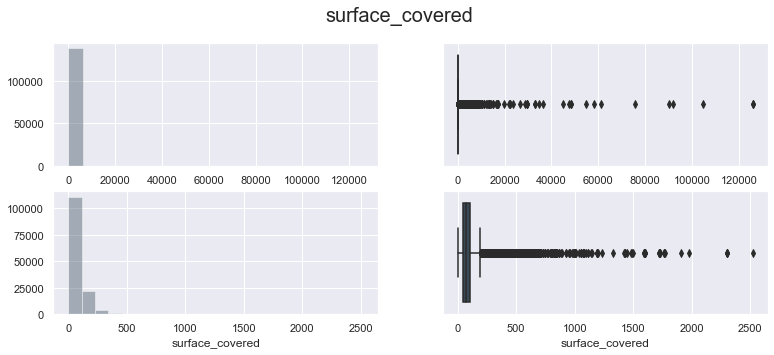

In [22]:
data=sigma_3(data,'surface_covered')

In [23]:
index=data[data.surface_covered>data.surface_total].index
data.drop(index,inplace=True)

* `surface total`

valor minimo: -3215.15116582825
valor maximo: 3524.968760308872
Filas descartadas: 250


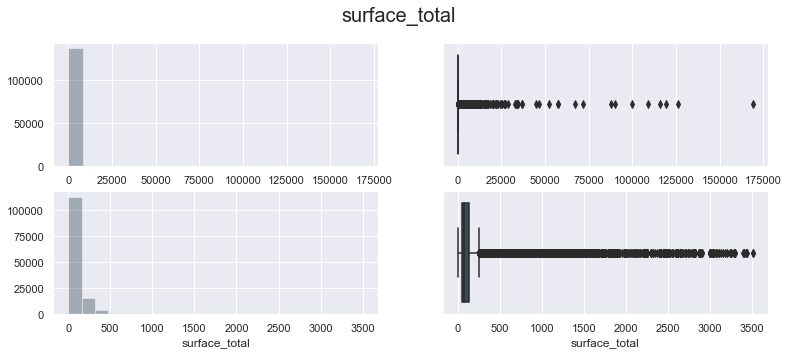

In [24]:
data=sigma_3(data,'surface_total')


* `Bathrooms`

valor minimo: -0.9020448231395319
valor maximo: 3.998173746750389
Filas descartadas: 4018


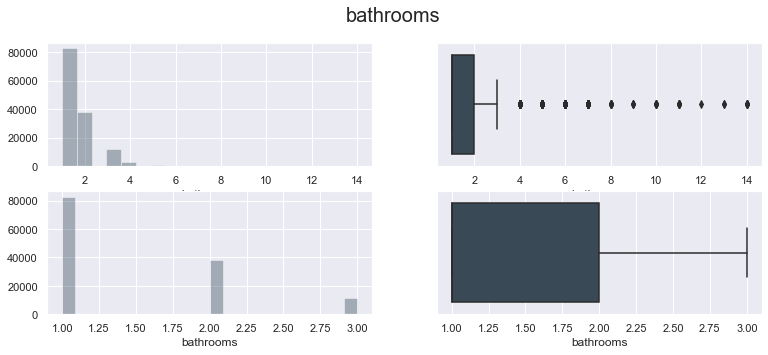

In [25]:
data=sigma_3(data,'bathrooms')


* `Bedrooms`

valor minimo: -1.2037850982452463
valor maximo: 5.027078876864578
Filas descartadas: 542


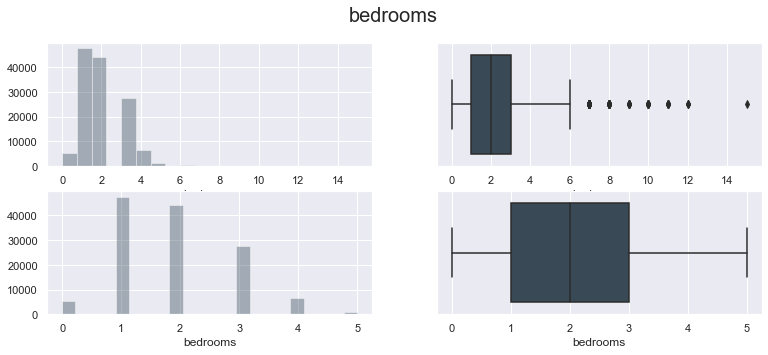

In [26]:
data=sigma_3(data,'bedrooms')


* `Rooms`

valor minimo: -0.6690804389959597
valor maximo: 6.5873485408313295
Filas descartadas: 1102


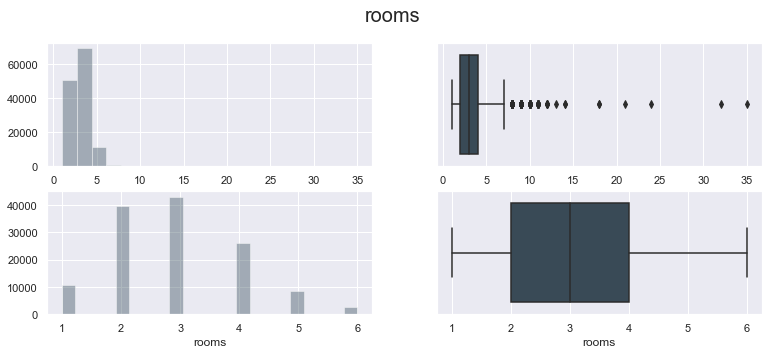

In [27]:
data=sigma_3(data,'rooms')

***

5. Encoding

Para incluir los datos de `property_type` agrego 3 columnas, una columna para `Departamento`, `PH` y `Casa`, donde hay 1 en la columna que corresponde y 0 en las otras dos. 

In [28]:
data['Departamento']=np.where(data.property_type=='Departamento',1,0)
data['PH']=np.where(data.property_type=='PH',1,0)
data['Casa']=np.where(data.property_type=='Casa',1,0)
data.drop('property_type',axis=1,inplace=True)

***
6. Escalado

Se realiza un escalado sobre las columnas que serán atributos del modelos dado que hay gran amplitud entre los valores de cada atributo. 

In [29]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X=data[['rooms','bedrooms','bathrooms','surface_total','surface_covered']]
Y=scaler.fit_transform(X)

In [30]:
data[['rooms','bedrooms','bathrooms','surface_total','surface_covered']]=Y

In [31]:
data.shape

(130915, 13)

***
7. Generación de nuevas variables predictoras/reducción de dimensionalidad

Se consideró que la clasificación `rooms` y `bedrooms` es inecesaria, por lo tanto se crea una nueva categoría llamada `ambientes`.

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
data['ambientes'] = pca.fit_transform(data[['rooms','bedrooms']]) 
data.drop(['rooms','bedrooms'],axis=1,inplace=True)
data.head()

,lat,lon,l2,l3,bathrooms,surface_total,surface_covered,price,Departamento,PH,Casa,ambientes
1,-34.624056,-58.412110,Capital Federal,Boedo,0.850843,-0.279263,-0.379813,159000.0,0,1,0,-1.210523
2,-34.593569,-58.427474,Capital Federal,Palermo,-0.702427,-0.430606,-0.604913,125000.0,0,1,0,-1.210523
3,-34.581294,-58.436754,Capital Federal,Palermo,-0.702427,-0.188456,-0.518336,295000.0,0,1,0,-1.210523
4,-34.914194,-57.938219,Bs.As. G.B.A. Zona Sur,La Plata,-0.702427,-0.400337,-0.778067,40000.0,0,1,0,-1.210523
5,-34.593779,-58.441239,Capital Federal,Villa Crespo,-0.702427,-0.364015,-0.414444,150000.0,0,1,0,-1.210523


***
8. Entrenos el primer modelo
    * Modelo del pryecto 01
    
    El modelo utilizado es un Arbol de decision regresor, utilizando la base de datos desde el checkpoint propuesto. 

In [33]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [34]:
def plot_RMSE(model,x_train,x_test,y_train,y_test):
    y_train_pred_tree = model.predict(x_train)
    y_test_pred_tree = model.predict(x_test)

    

    rmse_train_tree = np.sqrt(MSE(y_train, y_train_pred_tree))
    rmse_test_tree = np.sqrt(MSE(y_test, y_test_pred_tree))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train_tree}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
    print('\n')

    plt.figure(figsize = (6.4*2,4.8))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred_tree, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred_tree, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()
    plt.title('histograma de errores',fontsize=20)

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_tree, s =2)    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.title('Predicción Vs. Real',fontsize=20)    
    plt.tight_layout()
    plt.show()

Raíz del error cuadrático medio en Train: 149597.4593857805
Raíz del error cuadrático medio en Test: 162802.0503035136




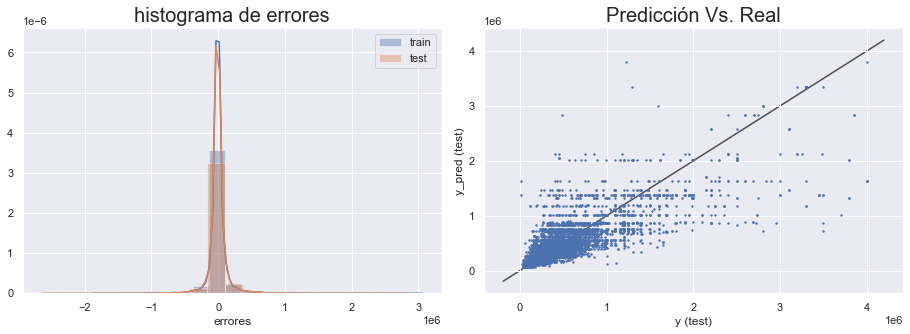

In [35]:
data2=properati[((properati.property_type=='Departamento')|(properati.property_type=='PH')|(properati.property_type=='Casa'))
               & (properati.l2=='Capital Federal')]

data2=data2[(data2['surface_total']<=1000)&(data2['surface_total']>15)]
data2=data2[(data2.price<=4000000)]
data2=data2[['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']]
data2.dropna(inplace=True)
data2.shape

X=data2[['rooms','bedrooms','bathrooms','surface_total','surface_covered']]
y=data2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

tree_regressor = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_regressor.fit(X_train, y_train)

sns.set()

plot_RMSE(tree_regressor,X_train, X_test, y_train, y_test)



***

* Mismo modelo con nuevo DataSet

In [36]:
X=data[['ambientes','bathrooms','surface_total','surface_covered','Departamento','PH','Casa']]
y=data['price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

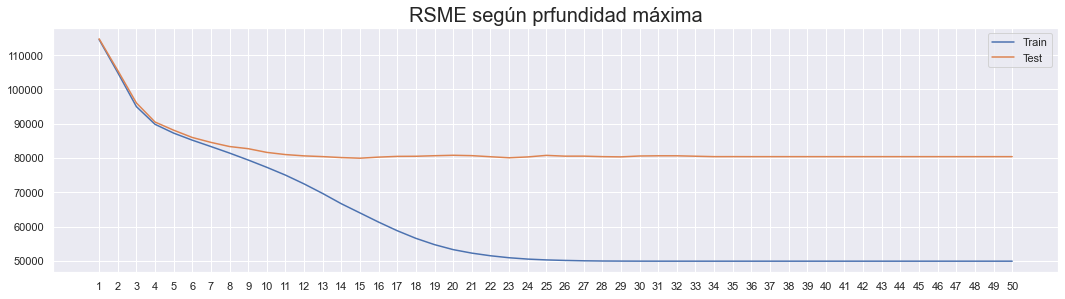

In [38]:
Y1=[]
Y2=[]
n=50
for i in range(n):
    tree_regressor = DecisionTreeRegressor(max_depth=i+1, random_state=42)
    tree_regressor.fit(X_train, y_train)
    y_train_pred = tree_regressor.predict(X_train)
    y_test_pred = tree_regressor.predict(X_test)
    y1 = np.sqrt(MSE(y_train, y_train_pred))
    Y1 = np.append(Y1,y1)
    y2 = np.sqrt(MSE(y_test, y_test_pred))
    Y2 = np.append(Y2,y2)

plt.figure(figsize = (6*3,4.5))
plt.plot(np.arange(1,n+1),Y1,label='Train')
plt.plot(np.arange(1,n+1),Y2,label='Test')
plt.xticks(np.arange(1, 51, step=1))
plt.legend()
plt.grid(b=True)
plt.title('RSME según prfundidad máxima',fontsize=20)
plt.show()

Raíz del error cuadrático medio en Train: 83327.04108183559
Raíz del error cuadrático medio en Test: 84542.55640109304




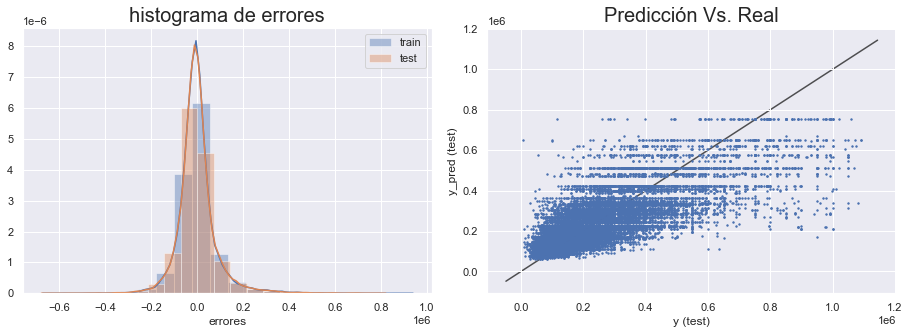

In [39]:
tree_regressor = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_regressor.fit(X_train, y_train)

plot_RMSE(tree_regressor,X_train, X_test, y_train, y_test)


Utilizando los mismos hiperparametros para el modelo del Proyecto 01 se puede observar una mejora sustancial en el rendimiento del modelo. Se observa una disminución en la métrica del RMSE, esto se debe principalmente a la disminución de outliers, en especial la del atributo `price`.
***
***

### Parte B - Modelos Avanzados
Para esta sección se utilizarán dos modelos avanzados, la Raregresión Avanzada y el Random Forest. Se realizarán la optimización de hiperparametros utilizando el Random Search y el Grid Search. Se continuará utilizando la métrica de RSME para comparar los resultados y definir cuál es el mejor modelo. 

#### 1. Regresión avanzada

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [41]:
X=data[['ambientes','bathrooms','surface_total','surface_covered','Departamento','PH','Casa']]
y=data['price']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Debido a que el problema no tiene forma de regresión lineal, se utilizara el método PolynomialFeatures para aproximar la base de datos a un problema de regresión lineal. Se definió que el grado sea 3, debido a que un grado mayor tiene un costo computacional muy grande.

In [43]:
poly = PolynomialFeatures(degree = 3, include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train_new.shape)

(98186, 119)


Se utilizará el modelo Ridge para la regularización. 

In [44]:
reg_ridge = Ridge()

In [45]:
from sklearn.model_selection import RandomizedSearchCV

Los hiperparametros a analizar son:
* `Alpha`: Hiperparametro más relevante, tiene que ser mayor a 1, pero si es muy grande puede causar Overfitting. (1 a 10 con un paso de 0.09)
* `Solver`: Se prueban distintos solver para ver cúal es el más conveniente para estos datos. Se excluyen sag y saga debido al costo computacional. ('svd','lsqr','cholesky', 'sparse_cg')

In [46]:
param_grid = {'alpha':np.linspace(1,10,num=100,endpoint=True),
              'solver':['svd','lsqr','cholesky', 'sparse_cg'],
              'random_state':[0]}

In [47]:
%%time
modelr = RandomizedSearchCV(reg_ridge, param_grid,n_iter=100, random_state=0, cv=3)
modelr.fit(X_train_new, y_train)
scores = pd.DataFrame(modelr.cv_results_)
scores

Wall time: 2min 48s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_random_state,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.783195,0.018190,0.011304,0.000470,svd,0,4,"{'solver': 'svd', 'random_state': 0, 'alpha': ...",0.610697,0.305357,0.616449,0.510834,0.145313,53
1,0.285986,0.027672,0.013299,0.004701,lsqr,0,8,"{'solver': 'lsqr', 'random_state': 0, 'alpha':...",0.480063,0.195320,0.482256,0.385880,0.134749,94
2,0.286235,0.023276,0.010304,0.001696,lsqr,0,8.72727,"{'solver': 'lsqr', 'random_state': 0, 'alpha':...",0.480063,0.195319,0.482256,0.385879,0.134749,98
3,0.791230,0.028156,0.011303,0.000471,svd,0,5.45455,"{'solver': 'svd', 'random_state': 0, 'alpha': ...",0.610695,0.306307,0.616455,0.511152,0.144867,44
4,0.202127,0.002049,0.010970,0.001411,cholesky,0,6.54545,"{'solver': 'cholesky', 'random_state': 0, 'alp...",0.610693,0.307012,0.616460,0.511388,0.144535,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.200131,0.002859,0.010638,0.000940,cholesky,0,4.27273,"{'solver': 'cholesky', 'random_state': 0, 'alp...",0.610697,0.305536,0.616450,0.510894,0.145229,51
96,0.808116,0.047926,0.009642,0.000940,sparse_cg,0,4,"{'solver': 'sparse_cg', 'random_state': 0, 'al...",0.608942,0.431864,0.616502,0.552436,0.085313,16
97,0.196317,0.002994,0.010639,0.001694,cholesky,0,9.81818,"{'solver': 'cholesky', 'random_state': 0, 'alp...",0.610687,0.309094,0.616475,0.512085,0.143556,20
98,0.784465,0.023046,0.010810,0.000845,svd,0,7,"{'solver': 'svd', 'random_state': 0, 'alpha': ...",0.610692,0.307304,0.616462,0.511486,0.144398,39


Se toman las 10 mejores hiperparametros para reducir opciones. 

In [48]:
df=scores[scores.rank_test_score<=10].sort_values('rank_test_score').reset_index()
# par=['param_random_state','param_fit_intercept','param_normalize','param_solver','param_alpha']
par=['param_random_state','param_solver','param_alpha']
df[par]

,param_random_state,param_solver,param_alpha
0,0,sparse_cg,4.45455
1,0,sparse_cg,7.81818
2,0,sparse_cg,9.18182
3,0,sparse_cg,6.54545
4,0,sparse_cg,2.27273
5,0,sparse_cg,4.90909
6,0,sparse_cg,3.36364
7,0,sparse_cg,10
8,0,sparse_cg,5
9,0,sparse_cg,9.36364


In [49]:
%%time
from sklearn.model_selection import GridSearchCV
reg_ridge = Ridge()

param_grid = {'alpha':np.linspace(2,10,num=20,endpoint=True),
              'solver':['sparse_cg'],
              'random_state':[0]}
model = GridSearchCV(reg_ridge, param_grid,cv=4)
model.fit(X_train,y_train)

# scores = pd.DataFrame(model.cv_results_)
# scores

Wall time: 2.86 s


GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': array([ 2.        ,  2.42105263,  2.84210526,  3.26315789,  3.68421053,
        4.10526316,  4.52631579,  4.94736842,  5.36842105,  5.78947368,
        6.21052632,  6.63157895,  7.05263158,  7.47368421,  7.89473684,
        8.31578947,  8.73684211,  9.15789474,  9.57894737, 10.        ]),
                         'random_state': [0], 'solver': ['sparse_cg']})

In [50]:
print("Mejores parametros: "+str(modelr.best_params_))
print("Mejor Score: "+str(modelr.best_score_)+'\n')

Mejores parametros: {'solver': 'sparse_cg', 'random_state': 0, 'alpha': 4.454545454545455}
Mejor Score: 0.5529336022658572



Raíz del error cuadrático medio en Train: 85022.054287097
Raíz del error cuadrático medio en Test: 87300.22437236963




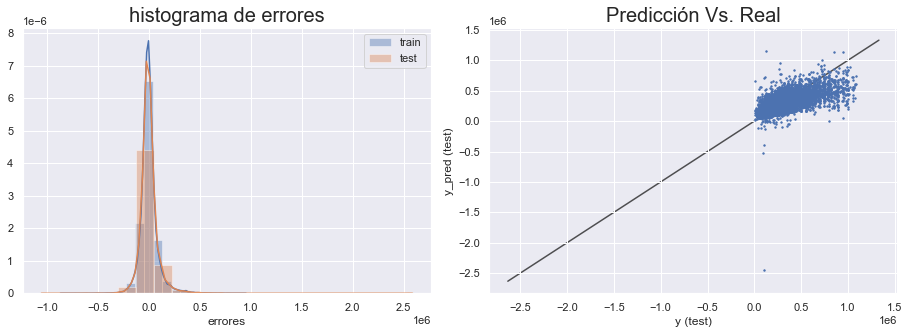

In [51]:
reg_ridge = Ridge(**modelr.best_params_)
reg_ridge.fit(X_train_new, y_train)
plot_RMSE(reg_ridge,X_train_new, X_test_new, y_train, y_test)

Habiendo buscado los mejores hiperparámetros se redujo considerablemente la métrica RSME comparado con el modelo del Proyecto 01. Pero observando el grafico comparativo de la Predicción Vs. Real se ve que algunas predicciones dieron valores negativos y eso no puede ser correcto. Si bien se observan pocas predicciones negativas, el hecho de que pueda darlas le quita confianza al modelo. 

***
#### 2. Random forest

Los hiperparámetros a analizar son:
* `n_estimators`: Número de árboles dentro del bosque. (1 a 200)
* `criterion`: Se utilizará `mse` debido a que `mae` tiene un costo computacional muy alto.
* `max_depth`: Con demasiada profundidad el modelo va a tener mucho costo computacional y un gran riesgo de Overfitting. (1 a 15)
* `max_features`: Distintos métodos para la cantidad de atributos para cada árbol. ('auto','sqrt','log2')

In [52]:
from sklearn.ensemble import RandomForestRegressor
RandF=RandomForestRegressor()

param_grid = {'n_estimators':np.arange(1,200),
              'criterion': ['mse'], 
              'max_depth':np.arange(1,15),
              'max_features':['auto','sqrt','log2'],
              'random_state': [42]}

*(El proceso puede tomar entre 25 y 40 min en mi computadora.)*

In [53]:
%%time
model = RandomizedSearchCV(RandF, param_grid, n_iter=100, random_state=0, cv=4)

model.fit(X_train,y_train)

scores = pd.DataFrame(model.cv_results_)
scores

Wall time: 24min 18s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_estimators,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.402509,0.049030,0.028922,0.003526,42,18,sqrt,5,mse,"{'random_state': 42, 'n_estimators': 18, 'max_...",0.590583,0.587381,0.587736,0.588934,0.588659,0.001251,73
1,0.546106,0.040406,0.031233,0.000547,42,75,sqrt,1,mse,"{'random_state': 42, 'n_estimators': 75, 'max_...",0.322762,0.327504,0.320970,0.328176,0.324853,0.003063,97
2,2.798033,0.091263,0.186267,0.008398,42,147,log2,5,mse,"{'random_state': 42, 'n_estimators': 147, 'max...",0.594589,0.596925,0.598144,0.602283,0.597985,0.002791,67
3,2.168557,0.110973,0.200832,0.005874,42,63,log2,11,mse,"{'random_state': 42, 'n_estimators': 63, 'max_...",0.670422,0.673397,0.678730,0.674893,0.674360,0.002992,25
4,1.944181,0.060282,0.126661,0.020033,42,185,sqrt,2,mse,"{'random_state': 42, 'n_estimators': 185, 'max...",0.435901,0.442651,0.435591,0.444847,0.439748,0.004078,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11.291049,0.761444,0.554276,0.077893,42,113,auto,14,mse,"{'random_state': 42, 'n_estimators': 113, 'max...",0.696898,0.706369,0.706370,0.703867,0.703376,0.003877,1
96,2.623392,0.137192,0.191882,0.022899,42,116,log2,6,mse,"{'random_state': 42, 'n_estimators': 116, 'max...",0.613075,0.615486,0.618941,0.620821,0.617080,0.003002,56
97,0.077711,0.002553,0.011470,0.001115,42,2,sqrt,12,mse,"{'random_state': 42, 'n_estimators': 2, 'max_f...",0.651952,0.658472,0.658361,0.651989,0.655194,0.003223,34
98,3.837039,0.245788,0.350369,0.005473,42,83,log2,14,mse,"{'random_state': 42, 'n_estimators': 83, 'max_...",0.695123,0.700099,0.705650,0.700968,0.700460,0.003735,4


Se toman las 10 mejores hiperparametros para reducir opciones. 

In [54]:
df=scores[scores.rank_test_score<=10].sort_values('rank_test_score').reset_index()
par=['param_random_state','param_n_estimators','param_max_features','param_max_depth','param_criterion']
df[par]

,param_random_state,param_n_estimators,param_max_features,param_max_depth,param_criterion
0,42,113,auto,14,mse
1,42,64,auto,14,mse
2,42,137,sqrt,14,mse
3,42,83,log2,14,mse
4,42,35,log2,14,mse
5,42,59,auto,13,mse
6,42,24,auto,13,mse
7,42,180,sqrt,13,mse
8,42,141,sqrt,13,mse
9,42,131,log2,13,mse


In [55]:
%%time
RandF=RandomForestRegressor()

param_grid = {'n_estimators':np.arange(120,190,2),
              'criterion': ['mse'], 
              'max_depth':np.arange(13,14),
              'max_features':['auto'],
              'random_state': [42]}
model = GridSearchCV(RandF, param_grid,cv=3)

model.fit(X_train,y_train)

# scores = pd.DataFrame(model.cv_results_)
# scores

Wall time: 20min 42s


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': array([13]),
                         'max_features': ['auto'],
                         'n_estimators': array([120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144,
       146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170,
       172, 174, 176, 178, 180, 182, 184, 186, 188]),
                         'random_state': [42]})

In [56]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'criterion': 'mse', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 184, 'random_state': 42}
Mejor Score: 0.6952225111584488



Raíz del error cuadrático medio en Train: 66692.71883961168
Raíz del error cuadrático medio en Test: 75575.15570232476




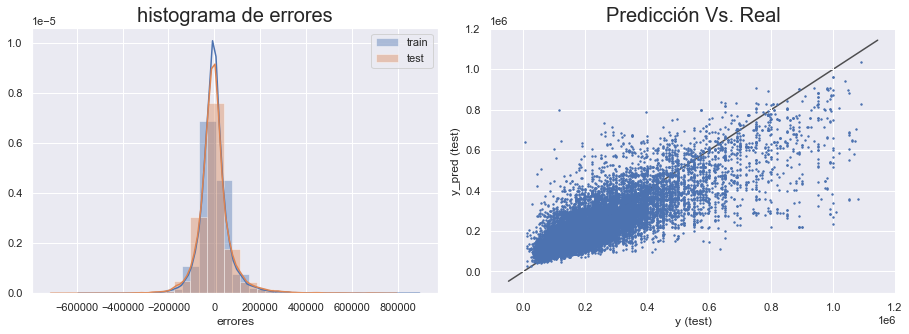

In [57]:
RandF=RandomForestRegressor(**model.best_params_)
RandF.fit(X_train,y_train)
plot_RMSE(RandF,X_train, X_test, y_train, y_test)
# RandF.score(X_test,y_test)

Luego de varias pruebas y de analizar varios resultados se definieron unos hiperparametros para el modelo de Random Forest y partiendo de esa base se buscó un numero de `max_depth`para reducir la diferencia entre el RSME del Train y Test:
* `n_estimators` = 184
* `max_features` = 'auto'
* `max_depth` =8 --> (Se redujo manualmente partiendo del 13)
* `criterion` = 'mse'
* `random_state` = 42

Raíz del error cuadrático medio en Train: 79805.01041408046
Raíz del error cuadrático medio en Test: 82052.32724569237




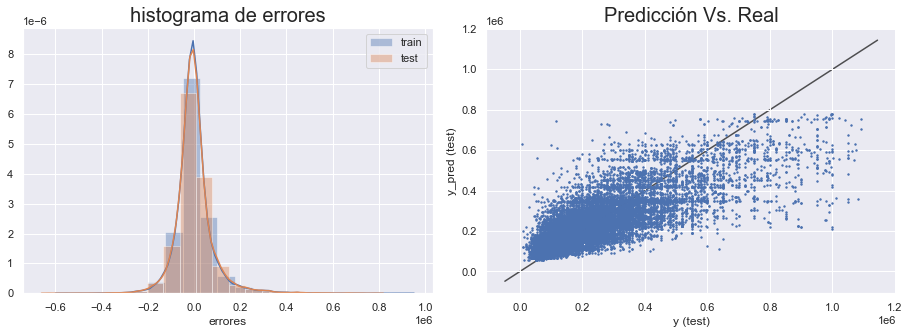

In [58]:
RandF=RandomForestRegressor(n_estimators=184,max_features='auto', max_depth=8,criterion='mse',random_state=42)
RandF.fit(X_train,y_train)
plot_RMSE(RandF,X_train, X_test, y_train, y_test)

En este modelo la métrica de RSME vuelve a disminuir, aunque queda una diferencia entre el RSME train y test, por lo que puede indicar que el modelo tiene un ligero Overfitting. A pesar de esta diferencia este modelo sigue siendo mejor que la Regresión avanzada, no tienen predicciones negativas y el histograma es más simétrico que el de la Regresión avanzada. 
***
***
### Parte C - Interpretación de modelos

En esta sección se analizaran detalles de los modelos. Para el modelo de Regresión avanzada se verán los coeficientes y la ordenada de la curva modelada y para el modelo de Random Forest se verán la importancia de los atributos utilizados.

* Regresión avanzada

In [59]:
print(f'Pendientes: {reg_ridge.coef_}')
print(f'Ordenada: {reg_ridge.intercept_}')

Pendientes: [-1.99757426e+03  1.65927319e+04  7.57703025e+03  5.16567061e+04
  2.02680351e+04 -7.82793787e+03 -1.24400972e+04  3.12166515e+01
 -7.18978913e+03  4.68408146e+03  5.45446282e+03 -3.31315779e+03
  7.84997552e+03 -6.53439199e+03 -3.53949451e+02 -3.66107482e+03
  1.80371006e+04  1.12621259e+04  1.13134738e+03  4.19925861e+03
 -7.05712889e+02 -4.92766122e+03  2.03843066e+04  2.86582731e+03
 -1.56731037e+04 -5.07151285e+03  4.61388836e+04  5.65406969e+03
 -1.36247163e+02  2.02680351e+04  0.00000000e+00  0.00000000e+00
 -7.82793787e+03  0.00000000e+00 -1.24400972e+04 -6.12130275e+02
  7.03119658e+02 -1.05500235e+03 -6.69653564e+02 -4.35237695e+03
 -6.47133681e+02  5.03072728e+03 -2.48077582e+03  2.48569325e+03
 -6.63734108e+02 -1.33002546e+03 -1.08965624e+03 -4.77010743e+03
 -2.36564184e+02 -1.22532871e+03  1.32446230e+03  8.23676215e+02
  2.53594294e+03  2.29959272e+02 -9.09339246e+02 -9.80845568e+02
  7.34464763e+03 -3.31315779e+03  0.00000000e+00  0.00000000e+00
  7.84997552e

Si bien se pueden observar los coeficientes y la ordenada, habiendo utilizado PolynomialFeatures, se pierde la noción del significado de cada columna, por lo que no es posible entender a que hace referencia cada coeficiente.

***

* Random Forest

Para analizar la importancia de los atributos se utilizaran dos métodos distintos, uno que utiliza el valor de importancia de Gini y el otro basado en la disminución media de la precisión. 

In [60]:
from sklearn.inspection import permutation_importance

def features (model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    model.fit(X_train,y_train)
    
    plt.figure(figsize = (10*2,6))

    plt.subplot(1,2,1)
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.title("Random Forest Feature Importance",fontsize=20)
    
    plt.subplot(1,2,2)
    perm_importance = permutation_importance(model, X_test, y_test)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.title("Permutation Importance",fontsize=20)
    plt.show()

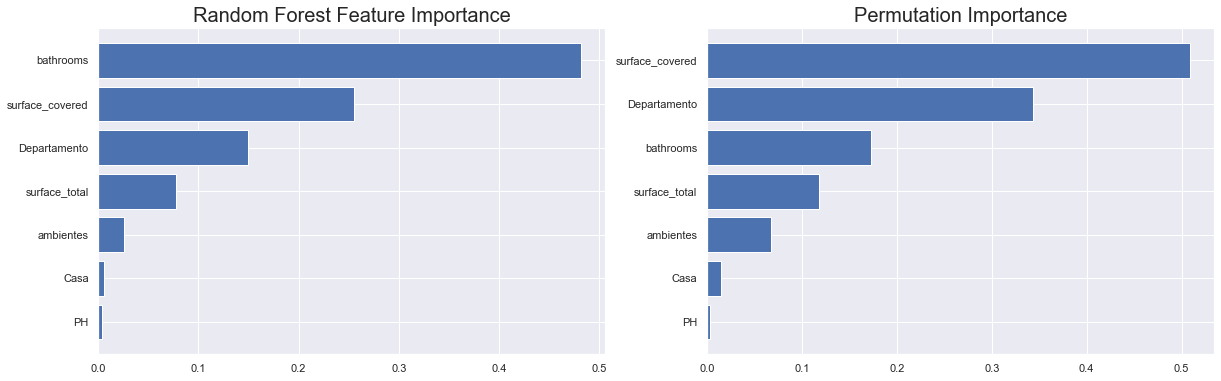

In [61]:
features(RandF,X,y)

Como se observa hay unas diferencias según que método se utiliza, pero se podrían distinguir los 3 atributos principales `surface_covered`, `bathrooms` y `Departamento`. Habiendo ya trabajado con este dataset, se puede decir la importancia de `surface_covered` tiene coherencia dado que era la que mayor correlación tenía con la columna `price`. En cuanto a la columna `bathrooms`, si bien ya tenía cierta correlación con `price`, es probable que el relleno de valores faltantes haya mejorado aún más esta correlación. Por último, la columna `Departamento`, siendo una columna agregada su importancia se debe relacionar a la enorme cantidad de propiedades que tienen esta categoría. La importancia de `surface_covered` y `bathrooms` se podría decir que es esperada dado los conocimientos del dataset, en cambio la importancia de `Departamento` es ligeramente inesperada, pero simultáneamente muestra que la creación de esta categoría fue una buena decisión. 

***
***

## Conclusión

Luego de todo el análisis podríamos a concluir que el preprocesamiento del dataset fue más sistemático y beneficioso para el modelo comparado con el preprocesamiento del Proyecto 01 y utilizando un modelo avanzado se pudieron obtener mejores resultados. 

En cuanto a oportunidades de mejora, durante el filtrado de valores atípicos, al aplicar el método de las 3 sigmas de manera sistemática, se aplicó un filtro más severo del que se podría permitir el dataset. Debido a esto varios atributos, como por ejemplo `bathrooms`, fueron acotados ampliamente y el modelo dejo de considerar las opciones fuera de esta acotación, algunos de estos valores que quedaron de lado para el modelo no son tan singulares como para que no puedan aparecer en el futuro (Ejemplo: el valor 4 de `bathrooms` quedo fuera del modelo y una casa no es extraño que pueda tener 4 baños).

